In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import math
import matplotlib.pyplot as plt

og = pd.read_csv('data.csv') # we won't change this one, just use it when we want to look at the original data

df = pd.read_csv('data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
ID           1000 non-null int64
survived     1000 non-null int64
pclass       1000 non-null int64
name         1000 non-null object
sex          1000 non-null object
age          796 non-null float64
sibsp        1000 non-null int64
parch        1000 non-null int64
ticket       1000 non-null object
fare         999 non-null float64
cabin        229 non-null object
embarked     999 non-null object
home.dest    575 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 101.6+ KB


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"Dorchester, MA"
1,1,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,"Winnipeg, MB"
2,2,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,NaN
3,3,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,NaN
4,4,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,NaN


In [3]:
# ID
# ID column is artifical and has nothing to do with the original data, so just drop it
df.drop(columns=['ID'], inplace=True)

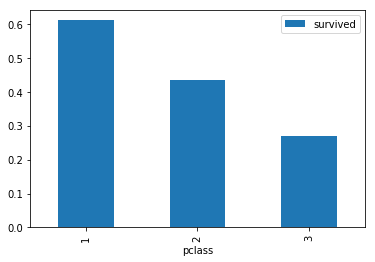

In [4]:
# pclass
# survival rate of 1st, 2nd and 3d class passengers
df[['pclass', 'survived']].groupby(['pclass']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# the result doesn't surprise us - 1st class passengers survived more often than 2nd class passengers and so on
# as the pclass columns is already numeric and categorical we don't have to do anything to it

In [5]:
# name
# at first glance the name column doesn't contain any useful information, but let's inspect it a little closer
df['name'].head(10)
# names are in this format: surname, title rest_of_the_name (and optionaly some name in brackets)

0                              McCarthy, Mr. Timothy J
1                                    Fortune, Mr. Mark
2                                 Sagesser, Mlle. Emma
3                         Panula, Master. Urho Abraham
4                                Maioni, Miss. Roberta
5                                 Waelens, Mr. Achille
6                               Reed, Mr. James George
7    Swift, Mrs. Frederick Joel (Margaret Welles Ba...
8       Smith, Mrs. Lucien Philip (Mary Eloise Hughes)
9                                   Rowe, Mr. Alfred G
Name: name, dtype: object

In [6]:
# let's add a new column for passenger's title
def get_title(row):
    title = re.search(', (\w*.) ', row['name'])
    if not title:
        return np.nan
    
    return title.group(1)
    
df['title'] = df.apply(lambda row: get_title(row), axis=1)    
df[['title']].groupby(['title']).size()
# there are 17 different titles but only 4 of them has higher occurrence than 5 (Mrs., Miss., Mr. and Master.)

title
Capt.          1
Col.           4
Don.           1
Dona.          1
Dr.            4
Jonkheer.      1
Lady.          1
Major.         2
Master.       46
Miss.        202
Mlle.          1
Mme.           1
Mr.          573
Mrs.         155
Ms.            2
Rev.           4
the            1
dtype: int64

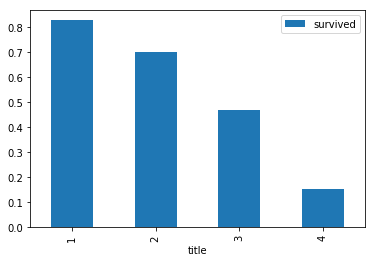

In [7]:
# we still have to transform titles into numeric values
female_titles_low_occurrence = ['Ms.', 'Mme.', 'Mlle.', 'Lady.', 'Dona.']
def get_title_numeric(row):
    title = get_title(row)
    # passengers with rare female titles like Lady might be the most likely ones to survive
    if (title in str(female_titles_low_occurrence)):
        return 1
    # women with Mrs. title are also very likely to survive, so we put them into the same category
    if (title == 'Mrs.'):
        return 1
    if (title == 'Miss.'):
        return 2
    if (title == 'Mr.'):
        return 4
    # put the rest of the male titles in one category
    return 3

df['title'] = df.apply(lambda row: get_title_numeric(row), axis=1)
# survival rate based on the title column
df[['title', 'survived']].groupby(['title']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# title column is obviously correlated with gender but it does provide some additional information so we keep it

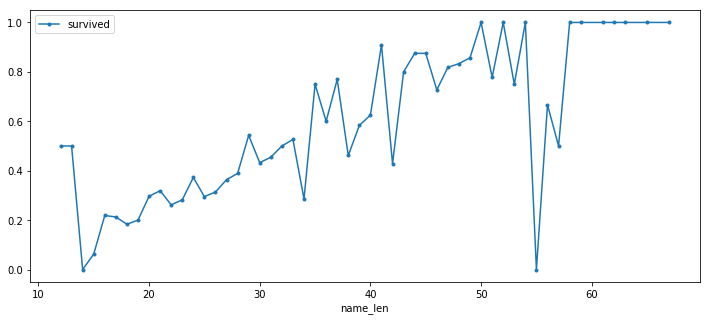

In [8]:
# let's add name_len column (maybe people with longer names are more nobel => they survived more often?)
df['name_len'] = df['name'].apply(len)
# plot the survival rate based on name_len values
df[['name_len', 'survived']].groupby(['name_len']).mean().sort_values(by='name_len').plot(marker='.', figsize=[12, 5])
# it's not really straightforward but we can roughly see, that passengers with longer names survived more often

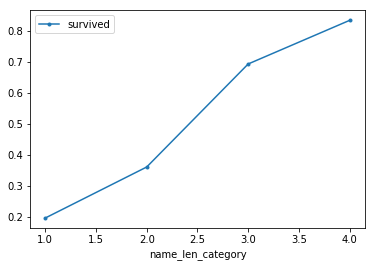

In [9]:
# let's transform name_len into 4 categories and see how it looks then
# the intervals were determined based on the plot above
def get_name_len_category(row):
    name_len = len(row['name'])
    # names shorter than 20 chars
    if (name_len < 20):
        return 1
    # names longer than 46 chars
    if (name_len > 46):
        return 4
    # names between 20 and 35 chars
    if (name_len < 35):
        return 2
    # names between 35 and 46 chars
    return 3

df['name_len_category'] = df.apply(lambda row: get_name_len_category(row), axis=1)
# plot the survival rate based on name_len_category values
df[['name_len_category', 'survived']].groupby(['name_len_category']).mean().plot(marker='.')
# difference here is kinda surprising (in a good way) so we definitely keep this column

# drop name_len, I don't know what else to do with the name column, so drop that as well
df.drop(columns=['name_len', 'name'], inplace=True)

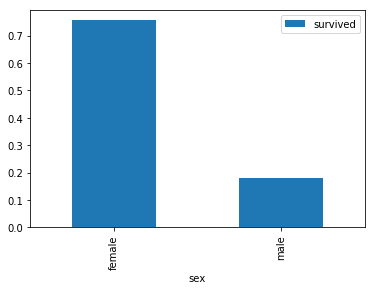

In [10]:
# sex
# survival rate of females vs males
df[['sex', 'survived']].groupby(['sex']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# as expected there is a strong correlation - females survived far more often than males

In [11]:
# now we have to map the string values to numeric values
df['sex'] = df['sex'].map({'male' : 0, 'female' : 1}).astype(int)

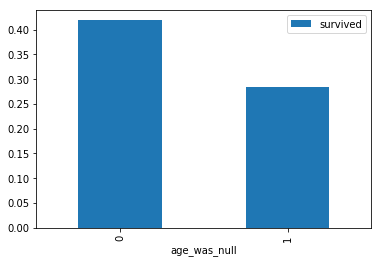

In [12]:
# age
# there are 304 missing values in the age column

# before we deal with the null values, let's add a flag column age_was_null 
df['age_was_null'] = np.where(df['age'].isnull(), 1, 0)

# survival rate based on the age_was_null column
df[['age_was_null', 'survived']].groupby(['age_was_null']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')

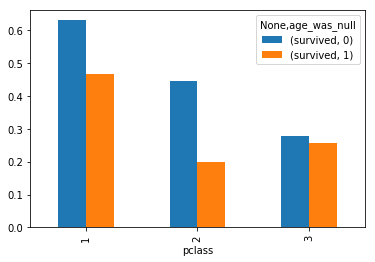

In [13]:
# there is some correlation among age_was_null and survived
# let's check whether the correlation is not cause by something else
# there could be more 3rd class/male passengers without filled age
# survival rate based on the age_was_null and pclass columns
df[['age_was_null', 'pclass', 'survived']].groupby(['pclass', 'age_was_null']).mean().sort_values(by=['pclass']).unstack().plot(kind='bar')
# we see that for every class passengers with filled age survived more often that passengers with age not filled

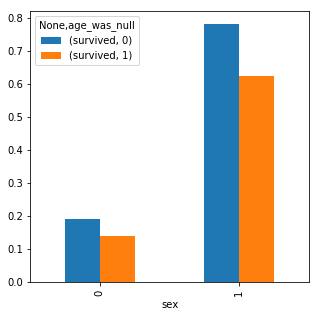

In [14]:
# just to make sure, we also check survival rate based on the age_was_null and sex columns
df[['age_was_null', 'sex', 'survived']].groupby(['sex', 'age_was_null']).mean().sort_values(by=['sex']).unstack().plot(kind='bar', figsize=[5,5])
# again, we see that males/females with filled age survived more often, so we keep the age_was_null column for now

In [15]:
# we still have to deal with the missing values
# we will probably want to use kNN for that, so we need to transform all the columns before we can use it

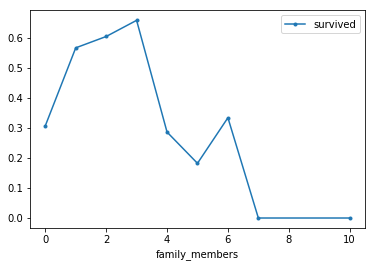

In [16]:
# sibsp and parch
# replace sibsp and parch columns with one family_members column
df['family_members'] = df['sibsp'] + df['parch']
# plot the survival rate based on family_members values
df[['family_members', 'survived']].groupby(['family_members']).mean().sort_values(by='family_members').plot(marker='.')
# we see that there is a higher survival rate for passengers with number of family_members equal to 1, 2, 3

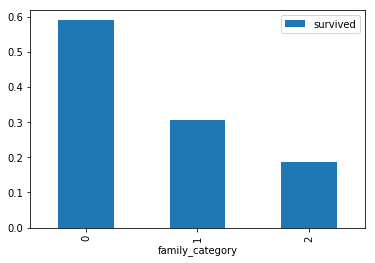

In [17]:
# let's transform the family_members column into family_category column
def get_family_category(row):
    # 0 family members = category 1
    if (row['sibsp']+row['parch'] == 0):
        return 1
    # 4 or more family members = category 2
    if (row['sibsp']+row['parch'] >= 4):
        return 2
    # 1 - 3 family members = category 0
    else:
        return 0

df['family_category'] = df.apply(lambda row: get_family_category(row), axis=1)
df.drop(columns=['family_members', 'sibsp', 'parch'], inplace=True)

# survival rate based on family_category values
df[['family_category', 'survived']].groupby(['family_category']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')

In [18]:
# ticket
print(df['ticket'].describe())
# not all of the tickets are unique, let's see the most frequent one
og.loc[og['ticket'] == 'CA. 2343']
# they all have the same surname - Sage, this indicates that passengers with same tickets traveled together

count         1000
unique         753
top       CA. 2343
freq            10
Name: ticket, dtype: object


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
106,106,0,3,"Sage, Mrs. John (Annie Bullen)",female,NaN,1,9,CA. 2343,69.55,NaN,S,NaN
495,495,0,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S,NaN
505,505,0,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
569,569,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
715,715,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
770,770,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
822,822,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
843,843,0,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,NaN
856,856,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN
937,937,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,NaN


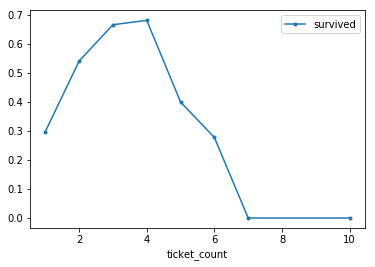

In [19]:
# we will add new ticket_count column indicating how many passengers traveled on the same ticket
ticket_counts = df[['ticket']].groupby(['ticket']).size().reset_index(name='count')
def get_ticket_count(row):
    ticket = row['ticket']
    return ticket_counts['count'].loc[ticket_counts['ticket'] == ticket].iloc[0]

df['ticket_count'] = df.apply(lambda row: get_ticket_count(row), axis=1)
# plot the survival rate based on ticket_count
df[['ticket_count', 'survived']].groupby(['ticket_count']).mean().sort_values(by='ticket_count').plot(marker='.')
# we can find some similarity with the plot based on family_members
# it's not completely same though, meaning we get some new information from it

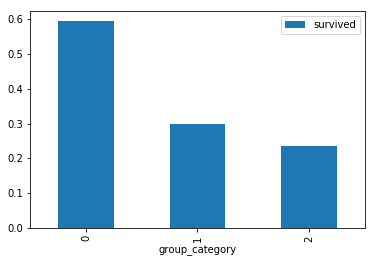

In [20]:
# transform ticket_count into group_category column
def get_group_category(row):
    ticket_count = get_ticket_count(row)
    # 1 passanger in the group = category 1
    if (ticket_count == 1):
        return 1
    # 5 or more passangers in the group = category 2
    if (ticket_count >= 5):
        return 2
    # 2 - 4 passangers in the group = category 0
    return 0
  
df['group_category'] = df.apply(lambda row: get_group_category(row), axis=1)
# drop ticket_count and ticket columns
df.drop(columns=['ticket_count', 'ticket'], inplace=True)

# survival rate based on group_category
df[['group_category', 'survived']].groupby(['group_category']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# the result is very similar to the family_group survival rate, let's hope this won't hurt us in the final model

In [21]:
# fare
print(df['fare'].describe())
# there are just 0.01% of data missing, so we won't use kNN here
# we expect that fare is the most dependent on the pclass
# replace missing value with it's pclass median
df['fare'] = df.groupby('pclass').apply(lambda x: x.fare.fillna(x.fare.median())).reset_index(level=0)['fare']

count    999.000000
mean      34.081201
std       52.381278
min        0.000000
25%        7.895800
50%       14.458300
75%       32.410400
max      512.329200
Name: fare, dtype: float64


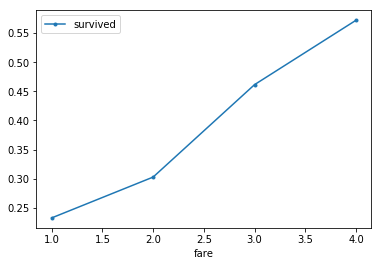

In [22]:
# separate fare into 4 categories of equal size
def get_fare_category(row):
    # fare lower than 7.895800 = category 1
    if (row['fare'] <= 7.895800):
        return 1
    # fare higher than 32.410400 = category 4
    if (row['fare'] > 32.410400):
        return 4
    # fare between 7.895800 and 14.458300 = category 2
    if (row['fare'] <= 14.458300):
        return 2
    # fare between 14.458300 and 32.410400 = category 2
    return 3

df['fare'] = df.apply(lambda row: get_fare_category(row), axis=1)
# plot survival rate by caterogical fare 
df[['fare', 'survived']].groupby(['fare']).mean().sort_values(by='fare').plot(marker='.')

In [23]:
# cabin
print(df['cabin'].describe())
# there are a lot of missing values, we won't bother with filling them (it would bring more noise than useful data)
df['cabin'].head(10)
# the cabins are in format: LetterNumber, sometimes multiple cabins for a single person
# let's look at Titanic's cutway diagram to get a better idea of what the Letters mean
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png")

count             229
unique            157
top       C23 C25 C27
freq                5
Name: cabin, dtype: object


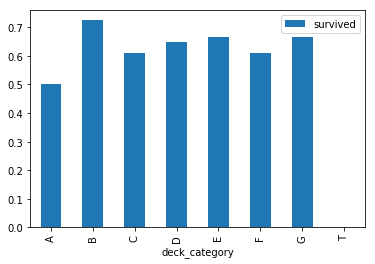

In [24]:
# it looks like deck level could've been important for survival as lifeboats are located on the top
# the cabin numbers might be important as well (maybe some numbers were closer to the exit doors)
# but that would require a much deeper analysis, so we'll settle with the deck letter
df.loc[df['cabin'].notnull(), 'deck_category'] = df['cabin'].str[0]
df[['deck_category', 'survived']].groupby(['deck_category']).mean().sort_values(by='deck_category').plot(kind='bar')
# this is a very surprising result, it looks like people from the deck A have the lowest survival rate
# this might be because almost 80% of the data is missing, so we will drop the deck_category feature
df.drop(columns=['deck_category'], inplace=True)

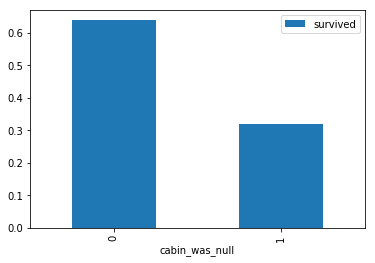

In [25]:
# before we drop the cabin column as well, let's try and add a flag feature cabin_was_null
df['cabin_was_null'] = np.where(df['cabin'].isnull(), 1, 0)

# survival rate based on the cabin_was_null column
df[['cabin_was_null', 'survived']].groupby(['cabin_was_null']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# the difference is even more surprising here

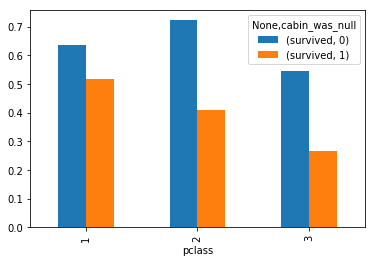

In [26]:
# survival rate based on the cabin_was_null and pclass columns
df[['cabin_was_null', 'pclass', 'survived']].groupby(['pclass', 'cabin_was_null']).mean().sort_values(by=['pclass']).unstack().plot(kind='bar')

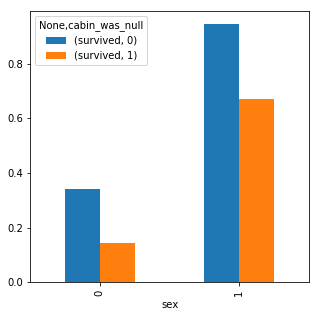

In [27]:
# just to make sure, we also check survival rate based on the cabin_was_null and sex columns
df[['cabin_was_null', 'sex', 'survived']].groupby(['sex', 'cabin_was_null']).mean().sort_values(by=['sex']).unstack().plot(kind='bar', figsize=[5,5])
# we will keep this column and drop the cabin column
df.drop(columns=['cabin'], inplace=True)

count     999
unique      3
top         S
freq      699
Name: embarked, dtype: object


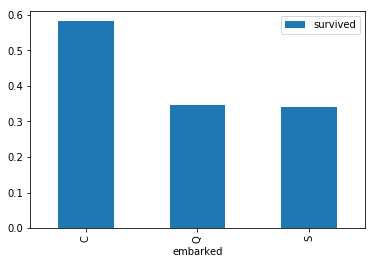

In [28]:
# embarked
print(df['embarked'].describe())
# there is one missing value, while the by far most common value is 'S'

# survival rate based on where passenger embarked
df[['embarked', 'survived']].groupby(['embarked']).mean().plot(kind='bar')
# passengers embarked in Cherbourg survived more often, so we keep this column

In [29]:
# let's replace the one missing value with median ('S')
df['embarked'].fillna('S', inplace=True)
# and map chars to numbers
df['embarked'] = df['embarked'].map({'C' : 1, 'Q' : 2, 'S' : 3}).astype(int)

count              575
unique             325
top       New York, NY
freq                46
Name: home.dest, dtype: object


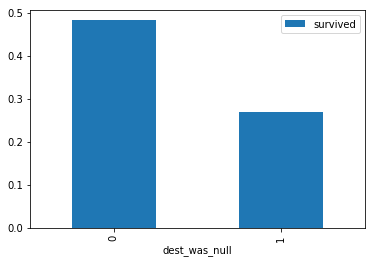

In [30]:
# home.dest
print(df['home.dest'].describe())
# there are too many missing values in this column, but before we drop it, let's add dest_was_null column
df['dest_was_null'] = np.where(df['home.dest'].isnull(), 1, 0)
df.drop(columns=['home.dest'], inplace=True)
# survival rate based on the age_was_null column
df[['dest_was_null', 'survived']].groupby(['dest_was_null']).mean().sort_values(by='survived', ascending=False).plot(kind='bar')
# this is surprising, but dest_was_null seems to have a big impact on the survival rate

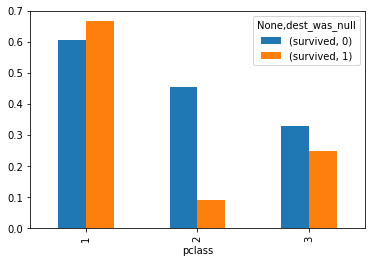

In [31]:
# we have to check whether the correlation isn't caused by something else (just like when we added age_was_null)
df[['dest_was_null', 'pclass', 'survived']].groupby(['pclass', 'dest_was_null']).mean().sort_values(by=['pclass']).unstack().plot(kind='bar')
# the results are not as pleasing as we would like them to be - results are different for pclass=1
# but there is huge difference in survival rate for pclass=2, so we won't drop the column yet

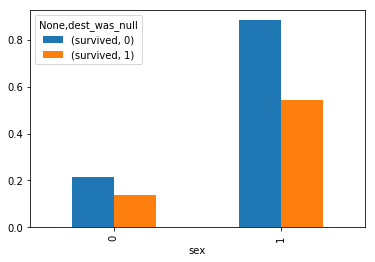

In [32]:
df[['dest_was_null', 'sex', 'survived']].groupby(['sex', 'dest_was_null']).mean().sort_values(by=['sex']).unstack().plot(kind='bar')
# the results are pleasing this time, we keep this column for now

In [33]:
# now that we have dealt with all the features we can finaly deal with the age using kNN
# we want to figure out what hyperparameters to use first
# get the data with filled age, we will use those as train, val and test data
df_age_not_null = df.loc[df['age_was_null'] == 0].reset_index()
# drop index (product of reset_index())
df_age_not_null.drop(columns=['index'], inplace=True)

# let's see the correlations between age and other columns
print(df.corrwith(df.age))

# we'll drop those with very weak correlation
df_age_not_null.drop(columns=['sex', 'title', 'name_len_category', 'family_category', 'age_was_null'], inplace=True)

survived            -0.069022
pclass              -0.406653
sex                 -0.056081
age                  1.000000
fare                 0.158888
embarked            -0.081413
title                0.031589
name_len_category    0.080247
age_was_null              NaN
family_category     -0.057252
group_category      -0.030525
cabin_was_null      -0.310662
dest_was_null       -0.179768
dtype: float64


In [34]:
#function for splitting the data into train, val, and test
from sklearn.model_selection import train_test_split

def split_data(data, Y_column, ratio=0.25):
    rd_seed = 333
    X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=[Y_column]), data[Y_column], test_size=ratio, random_state=rd_seed) 
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=ratio, random_state=rd_seed) 
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

# drop survived column as we won't have that in the evaluation data anyways
X_train, X_test, X_val, Y_train, Y_test, Y_val = split_data(df_age_not_null.drop(columns=['survived']), 'age')

In [35]:
# the age feature is continous for now, so we will use kNN regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ParameterGrid
import sklearn.metrics as metrics

param_grid = {
    'n_neighbors': range(1,10),
    'p' : range(1,3)
}
param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    kNN =  KNeighborsRegressor(**params)
    kNN.fit(X_train, Y_train)
    val_acc.append(math.sqrt(metrics.mean_squared_error(Y_val, kNN.predict(X_val))))
    
best_params = param_comb[np.argmin(val_acc)]
print(best_params)

kNN = KNeighborsRegressor(**best_params)
kNN.fit(X_train, Y_train)
print('RMSLE (test): {0:.6f}'.format(math.sqrt(metrics.mean_squared_error(Y_test, kNN.predict(X_test)))))

{'p': 2, 'n_neighbors': 9}
RMSLE (test): 12.795811


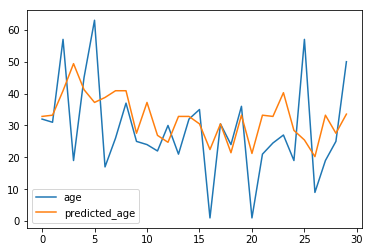

In [36]:
# the RMSLE looks really high, let's look at the data
Y_predicted = pd.DataFrame()
Y_predicted['predicted_age'] = kNN.predict(X_test)
Y_test = pd.DataFrame(data=Y_test)
Y_test = Y_test.reset_index()
Y_test.drop(columns=['index'], inplace=True)
Y_test['predicted_age'] = Y_predicted['predicted_age']

# plot the first 30 rows
Y_test.head(30).plot()
# we can see that the model has big problems with predicting ages bellow 20 and above 40
# but it's definitely better than random guessing or replacing missing ages with median

In [37]:
# train the model on all the data we've got using the hyperparameters in best_params
kNN = KNeighborsRegressor(**best_params) # this is redundant for better readability
kNN.fit(df_age_not_null.drop(columns=['age', 'survived']), df_age_not_null['age'])

# function that will fill null age values in data using the passed model
def fill_age(data, model):
    # get the data with age not filled
    data_age_null = data.loc[data['age'].isnull()]
    
    # drop columns that have very low correlation with the age column
    data_age_null.drop(columns=['sex', 'title', 'name_len_category', 'family_category', 'age_was_null'], inplace=True)
    
    # if there is 'survived' columns, drop it
    if 'survived' in data_age_null:
        data_age_null.drop(columns=['survived'], inplace=True)
    
    X_data_age_null = data_age_null.drop(columns=['age'])
    # fill the data
    data.loc[data['age'].isnull(), 'age'] = kNN.predict(X_data_age_null)

    return data
                       
df = fill_age(df, kNN)
# we get some kind of warning, that we're working on a copy not on the original object, but we don't really care

/home/skluzada/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


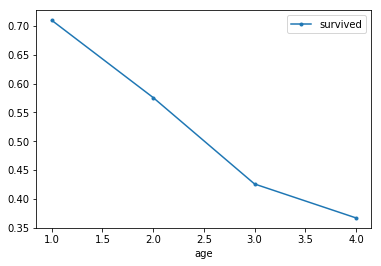

In [38]:
# the last thing we want to do is categorize the age column
def get_age_category(row):
    # passengers of age 0 - 3 = category 1
    if (row['age'] <= 3):
        return 1
    # passengers of age 4 - 9 = category 2
    if (row['age'] <= 9):
        return 2
    # passengers of age 10 - 18 = category 3
    if (row['age'] <= 18):
        return 3
    # passengers older than 19 = category 4
    return 4
    
df['age'] = df.apply(lambda row: get_age_category(row), axis=1)
# plot survival rate by caterogical fare 
df[['age', 'survived']].groupby(['age']).mean().sort_values(by='age').plot(marker='.')

In [39]:
# transform data from evaluation.csv (apply same transformations we did on the data.csv)
evaluation = pd.read_csv('evaluation.csv')
# ID
evaluation.drop(columns=['ID'], inplace=True)

# title
evaluation['title'] = evaluation.apply(lambda row: get_title_numeric(row), axis=1)

# name_len_category
evaluation['name_len_category'] = evaluation.apply(lambda row: get_name_len_category(row), axis=1)

# name
evaluation.drop(columns=['name'], inplace=True)

# sex
evaluation['sex'] = evaluation['sex'].map({'male' : 0, 'female' : 1}).astype(int)

# age_was_null
evaluation['age_was_null'] = np.where(evaluation['age'].isnull(), 1, 0)

# family_category
evaluation['family_category'] = evaluation.apply(lambda row: get_family_category(row), axis=1)

# sibsp and parch
evaluation.drop(columns=['sibsp', 'parch'], inplace=True)

# group_category
ticket_counts = evaluation[['ticket']].groupby(['ticket']).size().reset_index(name='count')
evaluation['group_category'] = evaluation.apply(lambda row: get_group_category(row), axis=1)

# ticket
evaluation.drop(columns=['ticket'], inplace=True)

# fare
evaluation['fare'] = evaluation.groupby('pclass').apply(lambda x: x.fare.fillna(x.fare.median())).reset_index(level=0)['fare']
evaluation['fare'] = evaluation.apply(lambda row: get_fare_category(row), axis=1)

# cabin_was_null
evaluation['cabin_was_null'] = np.where(evaluation['cabin'].isnull(), 1, 0)

# cabin
evaluation.drop(columns=['cabin'], inplace=True)

# embarked
evaluation['embarked'].fillna('S', inplace=True)
evaluation['embarked'] = evaluation['embarked'].map({'C' : 1, 'Q' : 2, 'S' : 3}).astype(int)

# dest_was_null
evaluation['dest_was_null'] = np.where(evaluation['home.dest'].isnull(), 1, 0)

# home.dest
evaluation.drop(columns=['home.dest'], inplace=True)

# age
evaluation = fill_age(evaluation, kNN)
evaluation['age'] = evaluation.apply(lambda row: get_age_category(row), axis=1)
# we get some kind of warning, that we're working on a copy not the original object, but we don't really care about that

/home/skluzada/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
# let's look at the data now
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
survived             1000 non-null int64
pclass               1000 non-null int64
sex                  1000 non-null int64
age                  1000 non-null int64
fare                 1000 non-null int64
embarked             1000 non-null int64
title                1000 non-null int64
name_len_category    1000 non-null int64
age_was_null         1000 non-null int64
family_category      1000 non-null int64
group_category       1000 non-null int64
cabin_was_null       1000 non-null int64
dest_was_null        1000 non-null int64
dtypes: int64(13)
memory usage: 101.6 KB


,survived,pclass,sex,age,fare,embarked,title,name_len_category,age_was_null,family_category,group_category,cabin_was_null,dest_was_null
0,0,1,0,4,4,3,4,2,0,1,0,0,0
1,0,1,0,4,4,3,4,1,0,2,2,0,0
2,1,1,1,4,4,1,1,2,0,1,0,0,1
3,0,3,0,1,4,3,3,2,0,2,2,1,1
4,1,1,1,3,4,3,2,2,0,1,0,0,1


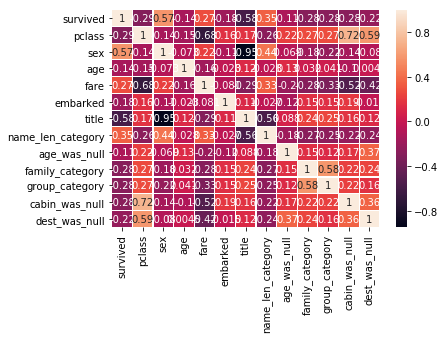

In [41]:
# correlation matrix
sns.heatmap(df.corr(), linewidths=0.1, annot=True)

In [42]:
# Aplikujte všechny klasifikační modely z přednášek
# Klasifikacni modely probrane do 18.11.2018:
# 1) Decision Tree Classifier
# 2) Random Forest Classifier
# 3) Ada Boost Classifier
# 4) kNN
# 5) Naive Bayes

In [43]:
# split the data
# I've had my doubs about the group_category feature and the models works better when leave it out
df.drop(columns=['group_category'], inplace=True)
X_train, X_test, X_val, Y_train, Y_test, Y_val = split_data(df, 'survived')

In [119]:
df.drop(columns=['age_was_null', 'dest_was_null', 'embarked'], inplace=True)

In [120]:
# 1a) Decision Tree Classifier
# using GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
parameters = {
    'max_depth': range(1,20),
    'criterion': ['entropy', 'gini']
}
dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
dt.fit(X=X_train, y=Y_train)
print(dt.best_params_)
print('accuracy score (best score): {0:.6f}'.format(dt.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, dt.predict(X_val))))

{'criterion': 'gini', 'max_depth': 5}
accuracy score (best score): 0.822064
accuracy score (validation): 0.803191


{'max_depth': 3, 'criterion': 'entropy'}
accuracy score (train): 0.813167
accuracy score (validation): 0.829787


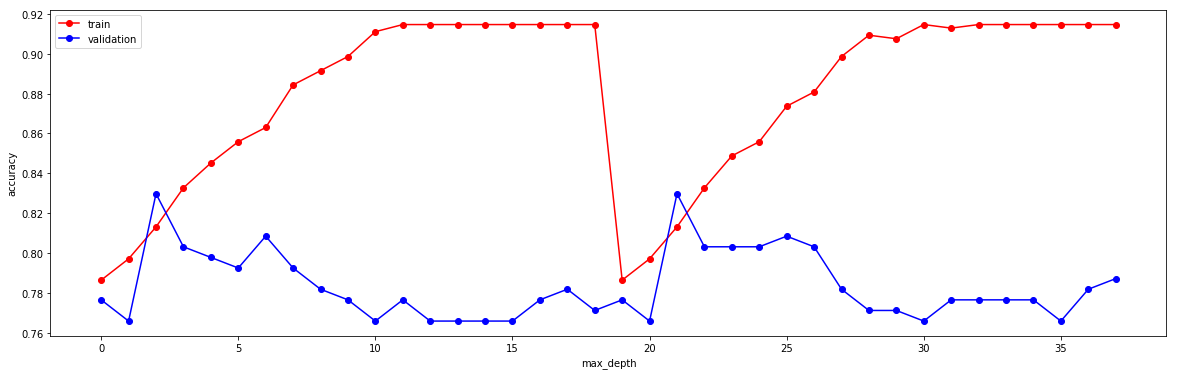

In [45]:
# 1b) Decision Tree Classifier
# not using cross validation
parameters = {
    'max_depth': range(1,20), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(parameters)
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(**params)
    dt.fit(X_train, Y_train)
    train_acc.append(metrics.accuracy_score(Y_train, dt.predict(X_train)))
    val_acc.append(metrics.accuracy_score(Y_val, dt.predict(X_val)))
    
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

best_params = param_comb[np.argmax(val_acc)]
print(best_params)

dt = DecisionTreeClassifier(**best_params)
dt.fit(X_train, Y_train)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(Y_train, dt.predict(X_train))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, dt.predict(X_val))))

In [46]:
# we've got different results (as expected?)
# if we look at the graph though, we see that the validation data accuracy was better than training which is a bit odd
# we'll stick with using the GridSearchCV as it's a lot more convenient

In [121]:
# 2) Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators': range(1, 66, 5),
    'max_depth': range(1, 10)
}
rf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
rf.fit(X=X_train, y=Y_train)
print(rf.best_params_)
print('accuracy score (best score): {0:.6f}'.format(rf.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, rf.predict(X_val))))

{'max_depth': 5, 'n_estimators': 36}
accuracy score (best score): 0.820285
accuracy score (validation): 0.829787


In [122]:
# 3) Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
parameters = {
    'n_estimators': range(1, 66, 5),
    'learning_rate': range(1, 3)
}
ab = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
ab.fit(X=X_train, y=Y_train)
print(ab.best_params_)
print('accuracy score (best score): {0:.6f}'.format(ab.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, ab.predict(X_val))))

{'learning_rate': 1, 'n_estimators': 46}
accuracy score (best score): 0.807829
accuracy score (validation): 0.840426


In [49]:
# 4) kNN
from sklearn.neighbors import KNeighborsClassifier
parameters = {
    'n_neighbors': range(1,25),
    'p' : range(1,3)
}
kNN = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
kNN.fit(X=X_train, y=Y_train)
print(kNN.best_params_)
print('accuracy score (best score): {0:.6f}'.format(kNN.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, kNN.predict(X_val))))

{'n_neighbors': 13, 'p': 2}
accuracy score (best score): 0.832740
accuracy score (validation): 0.824468


In [50]:
# 5a) Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB
parameters = {
}
gnb = GridSearchCV(GaussianNB(), parameters, cv=5)
gnb.fit(X=X_train, y=Y_train)
print(gnb.best_params_)
print('accuracy score (best score): {0:.6f}'.format(gnb.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, gnb.predict(X_val))))

{}
accuracy score (best score): 0.772242
accuracy score (validation): 0.803191


In [51]:
# 5b) Naive Bayes (MultinomialNB)
from sklearn.naive_bayes import MultinomialNB
parameters = {
    'alpha': range(1, 10, 1)
}
mnb = GridSearchCV(MultinomialNB(), parameters, cv=5)
mnb.fit(X=X_train, y=Y_train)
print(mnb.best_params_)
print('accuracy score (best score): {0:.6f}'.format(mnb.best_score_))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(Y_val, mnb.predict(X_val))))

{'alpha': 4}
accuracy score (best score): 0.786477
accuracy score (validation): 0.824468


In [76]:
# we've got the best accuracy (based on validation data) using the Random Forest Classifier
# 0.851064 for parameters: {'max_depth': 3, 'n_estimators': 61}
final_model = RandomForestClassifier(max_depth=3, n_estimators=61)
final_model.fit(X_train, Y_train)
print('test accuracy score: {0:.6f}'.format(metrics.accuracy_score(Y_test, final_model.predict(X_test))))

test accuracy score: 0.836000


In [80]:
# we trained the model on the data without group_category feature, so we have to drop it here as well
evaluation.drop(columns=['group_category'], inplace=True)
evaluation['survived'] = final_model.predict(evaluation)

In [112]:
# we've deleted the ID column, so we're gonna have to get it back
evaluation = evaluation.reset_index()
evaluation.rename(index=str, columns={'index': 'ID'}, inplace=True)
# IDs in the evaluation.csv starts from 1000
evaluation['ID'] = evaluation['ID'] + 1000

In [118]:
# get the ID and survived into result
result = evaluation[['ID', 'survived']]
# export the result, the assignment says save only ID and survived, so we don't export the index
result.to_csv('result.csv', index=False)